# 0. Functions for later usage

### 0.0 Import libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import defaultdict
from colorama import Back, Fore
import inspect
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import plot_model
import inspect
import chardet
import sys
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

### 0.1 Function 1: display_filtered_images -> this function displays different pictures from our dataset

In [2]:
def display_filtered_images(df, age=None, ethnicity=None, gender=None, num_images=8, figsize=(20, 4)):
    """
    Display images filtered by age, ethnicity, and gender.
    
    Parameters:
    - df: DataFrame containing the image data and labels.
    - age: Filter for the age of the individuals (int or None).
    - ethnicity: Filter for the ethnicity of the individuals (int or None).
    - gender: Filter for the gender of the individuals (int or None).
    - num_images: Number of images to display.
    - figsize: Size of the figure.
    """
    
    # Apply filters
    filtered_df = df
    if age is not None:
        filtered_df = filtered_df[filtered_df['age'] == age]
    if ethnicity is not None:
        filtered_df = filtered_df[filtered_df['ethnicity'] == ethnicity]
    if gender is not None:
        filtered_df = filtered_df[filtered_df['gender'] == gender]
    
    # Ensure we don't try to display more images than available after filtering
    num_images = min(len(filtered_df), num_images)
    
    # Set up the plot
    fig, axes = plt.subplots(1, num_images, figsize=figsize)
    for i in range(num_images):
        # Directly use the pixel array if it's already in the correct format
        img_array = filtered_df.iloc[i]['pixels']
        if isinstance(img_array, np.ndarray):
            img_array = img_array.reshape(48, 48)  # Use directly if it's a numpy array
        else:
            img_array = img_array.numpy().reshape(48, 48)  # Convert to numpy array and then reshape
        ax = axes[i] if num_images > 1 else axes  # Handle case of num_images == 1
        # Display the image
        ax.imshow(img_array, cmap='gray')
        # Optionally, set a title with more information
        ax.set_title(f"Age: {filtered_df.iloc[i]['age']}\nEthnicity: {filtered_df.iloc[i]['ethnicity']}\nGender: {filtered_df.iloc[i]['gender']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


### 0.3 Function 3: calculate_combined_misclassification_info -> this function displays the absolute and relative volumes of missclassified instances/pictures broken down by age, gender and ethnicity.

In [3]:
def calculate_combined_misclassification_info(y_true, y_pred, data, category_names, age_bucket_size=5):
    """
    Calculate and print the misclassification rates and distribution for each label in each category,
    with ages bucketed into specified tranches.

    Parameters:
    - y_true: array-like of true labels
    - y_pred: array-like of predicted labels
    - data: DataFrame containing the category labels
    - category_names: list of column names in the DataFrame that are categories
    - age_bucket_size: size of the age buckets (default is 5 years)
    """
    # Initialize dictionaries to count total and misclassified instances per label
    total_counts = {name: defaultdict(int) for name in category_names}
    misclassified_counts = {name: defaultdict(int) for name in category_names}

    # Function to bucket the age
    def bucket_age(age):
        return f"{age // age_bucket_size * age_bucket_size}-{(age // age_bucket_size + 1) * age_bucket_size - 1}"

    # Iterate over the dataset and populate the counts
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        for name in category_names:
            category_value = data.iloc[i][name]
            if name == 'age':
                category_value = bucket_age(category_value)
                
            total_counts[name][category_value] += 1
            if true != pred:
                misclassified_counts[name][category_value] += 1

    # Now calculate and print the misclassification rates and distribution
    for name in category_names:
        print(f"\n{name} - Misclassification rates:")
        for category_value, count in sorted(total_counts[name].items()):
            misclassified = misclassified_counts[name][category_value]
            total = count
            percentage = (misclassified / total) * 100 if total > 0 else 0
            print(f"  {category_value}: Total = {total}, Misclassified = {misclassified} ({percentage:.2f}%)")

        print(f"\n{name} - Misclassification distribution:")
        total_misclassified = sum(misclassified_counts[name].values())
        for category_value, misclassified in sorted(misclassified_counts[name].items()):
            distribution_percentage = (misclassified / total_misclassified) * 100 if total_misclassified > 0 else 0
            print(f"  {category_value}: Misclassified = {misclassified} ({distribution_percentage:.2f}%) of Total Misclassified = {total_misclassified}")


## Identifying the device (either CPU or GPU) used with Keras & Tensorflow

https://www.tensorflow.org/api_docs/python/tf/config/list_physical_devices

This line of code is used to list all the physical GPU devices that are available for TensorFlow to use:

```python
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
```

https://www.tensorflow.org/api_docs/python/tf/config/experimental

```python
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
```

In [4]:
# Check if TensorFlow can access the GPU
print("Is a GPU available: ", tf.config.list_physical_devices('GPU'))
# Print the number of GPUs available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Is a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

This line of code is enabling memory growth for the first GPU device available for TensorFlow to use.

Memory growth allows TensorFlow to allocate GPU memory based on runtime needs, rather than allocating all available GPU memory upfront. 

```python
tf.config.experimental.set_memory_growth(gpus[0], True)
```


In [5]:
# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Prevent TensorFlow from initializing all of the GPU memory at once
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # Catch the runtime error if memory growth is set after GPU initialization
        print(e)
    
    device_name = tf.test.gpu_device_name()
    if device_name:
        print(f"OK: Using GPU: {device_name}")
    else:
        print("OK: GPU found, but no device name identified.")
else:
    print("KO: Using CPU")

OK: Using GPU: /device:GPU:0


## 1. We detect the file encoding
    ## age_gender.csv -> The detected encoding of the file is: ascii

In [6]:
def detect_file_encoding(file_path):
    """Detect the encoding of a given file."""
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read())
    return result['encoding']

# Example usage:
file_path = 'C:\\Users\\fercv\\OneDrive\\Desktop\\\AI_Master_Degree\\5_Deep_Learning\\data\\age_gender.csv'
detected_encoding = detect_file_encoding(file_path)

print(f'{Back.RED}The detected encoding of the file is:{Back.RESET}',
    f"\n{Back.BLUE}{detected_encoding}{Back.RESET}")

The detected encoding of the file is: 
ascii


## 2. We load our built-in functions for EDA

In [7]:
sys.path.append('C:\\Users\\fercv\\OneDrive\\Desktop\\Python\\00_Basics')
from Glimpse_20231230_v1 import DataFrameGlimpser
all_members = inspect.getmembers(DataFrameGlimpser)
function_members = [member for member in all_members if inspect.isfunction(member[1])]
for name, func in function_members:
    print(name)

print(f'{Back.RED}DataFrameGlimpser type:{Back.RESET}',
    f"\n{Back.BLUE}{type(DataFrameGlimpser)}{Back.RESET}")

__init__
calculate_additional_statistics
calculate_correlation_matrix
calculate_memory_savings
color_cells
display_comprehensive_statistics
display_correlation_matrix
display_custom_correlation_matrix
display_head_and_tail
display_html
display_index_information
display_info
display_missing_values
display_shape
display_summary_statistics
display_unique_values
generate_outlier_removal_snippet
glimpse
highlight_mad
highlight_outliers
highlight_variance
identify_potential_primary_keys
plot_missing_values_bar_chart
remove_outliers
set_df_name
suggest_and_display_data_type_changes
suggest_columns_to_drop
summarize_and_display_correlations
DataFrameGlimpser type: 
<class 'type'>


In [8]:
from Visualise_Data_20240217_v3 import DataVisualizer

all_members = inspect.getmembers(DataVisualizer)
function_members = [member for member in all_members if inspect.isfunction(member[1])]
for name, func in function_members:
    print(name)
    
print(f'{Back.RED}DataVisualizer type:{Back.RESET}',
    f"\n{Back.BLUE}{type(DataVisualizer)}{Back.RESET}")

__init__
reorder_categories
set_custom_palette
visualize_all
visualize_box_violin_plots
visualize_correlation_matrix
visualize_joint_plots
visualize_kdeplots
visualize_lm_line_plots
visualize_pairplots
visualize_strip_plots
DataVisualizer type: 
<class 'type'>


## 3. We load the dataset and perfom the EDA

In [9]:
#We load the data
age_gender_data = pd.read_csv(file_path, delimiter=',', encoding=detected_encoding)

In [10]:
print(f'{Back.RED}age_gender_data type:{Back.RESET}',
    f"\n{Back.BLUE}{type(age_gender_data)}{Back.RESET}")

age_gender_data type: 
<class 'pandas.core.frame.DataFrame'>


### 3.1 We understand the dataset structure, missing values and unique values for each variable

In [11]:
glimpser = DataFrameGlimpser(age_gender_data)
#glimpser.set_df_name('age_gender_data')  # Optional: Set a custom name
#glimpser.glimpse()
glimpser.display_head_and_tail()
glimpser.display_missing_values()
glimpser.display_unique_values()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


,age,ethnicity,gender,img_name,pixels
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...
23704,99,0,1,20170110182052119.jpg.chip.jpg,156 161 160 165 170 173 166 177 183 191 187 18...


Series([], dtype: int64)

age            104
ethnicity        5
gender           2
img_name     23479
pixels       23315
dtype: int64

In [12]:
print(age_gender_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB
None


### 3.2. We understand the images pixels size

In [13]:
# Assuming age_gender_data['pixels'][0] is a string of pixel intensities
num_pixels = len(age_gender_data['pixels'][0].split())
image_size = int(num_pixels ** 0.5)  # Assuming the images are square

print(f'{Back.RED}Each image is:{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}x{Back.RESET}',
    f"{Back.BLUE}{image_size}{Back.RESET}",
    f'{Back.RED}pixels{Back.RESET}',)

print(f'{Back.RED}The number of pixels per image is:{Back.RESET}',
    f"{Back.BLUE}{num_pixels}{Back.RESET}")

print(f'{Back.RED}num_pixels type:{Back.RESET}',
    f"\n{Back.BLUE}{type(num_pixels)}{Back.RESET}")

Each image is: 48 x 48 pixels
The number of pixels per image is: 2304
num_pixels type: 
<class 'int'>


### 3.3. We visualise the variables of our dataset

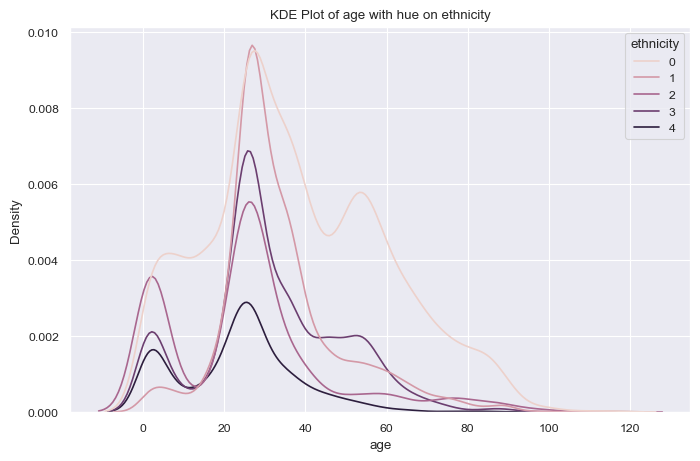

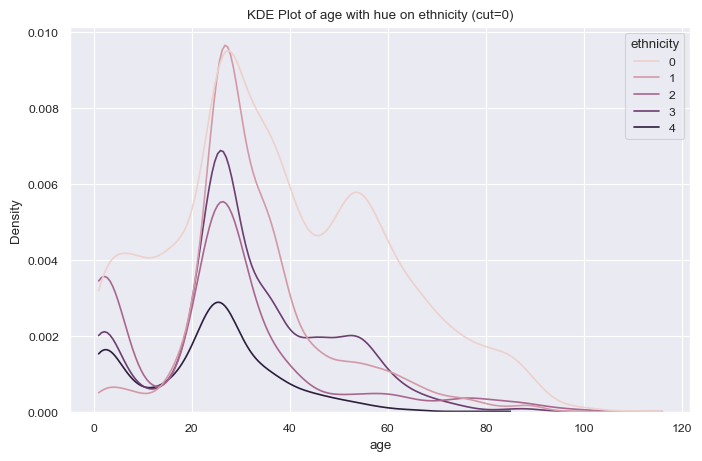

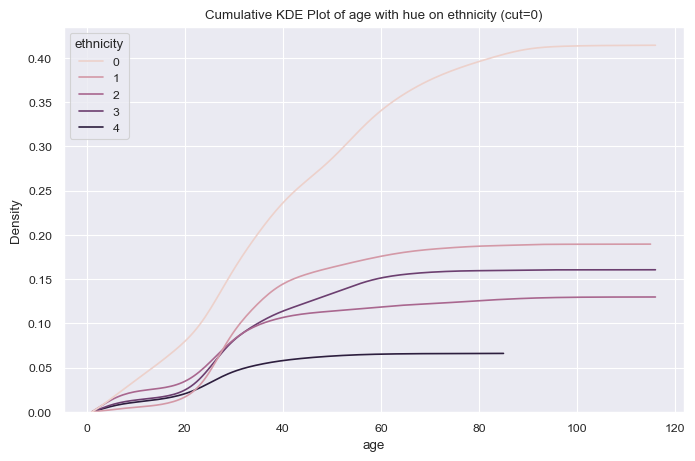

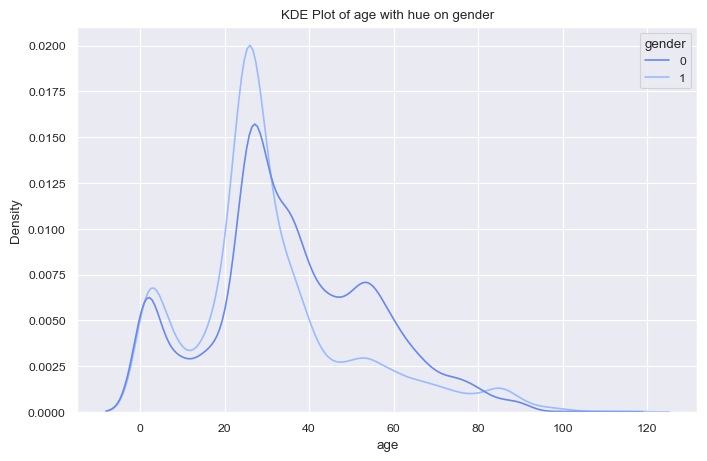

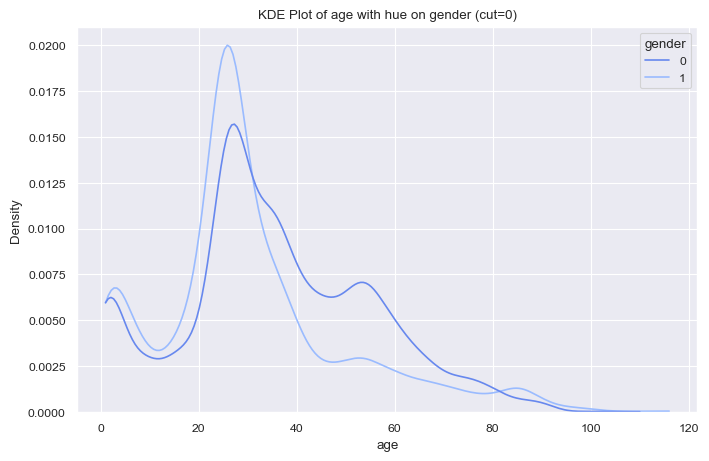

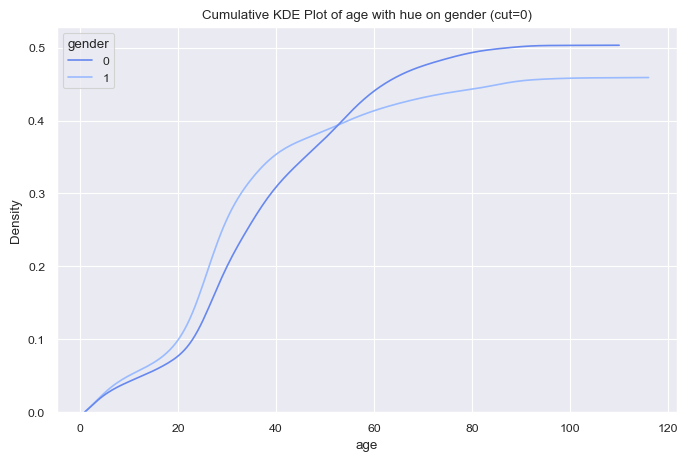

In [14]:
visualizer = DataVisualizer(age_gender_data, plot_width=8, plot_height=5)
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['ethnicity','gender'], hue=['ethnicity','gender'])
#visualizer.visualize_all(num_vars=['age','ethnicity'], cat_vars=['gender'], hue=['ethnicity','gender'])
visualizer.visualize_kdeplots(num_vars=['age'], hue=['ethnicity','gender'])

## 4- We print some pictures from our dataset to understand its content.

#### 4.0. We first apply the necessary transformations to convert the 'pixels' variable (with object type) to an array and later to a tensor

```python
return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))
```

This line of code is taking a string of pixel values, splitting it into a list, converting that list into a numpy array of type float32, and then reshaping that array into a 3D tensor with a shape of (48, 48,1)

In [15]:
# Define a function to convert pixel strings to tensors
def convert_pixels_to_tensor(pixels):
    return tf.reshape(np.array(pixels.split(), dtype="float32"), (48, 48,1))

# Copy the DataFrame and apply the conversion function
age_gender_data_tensor = age_gender_data.copy()
age_gender_data_tensor['pixels'] = age_gender_data['pixels'].apply(convert_pixels_to_tensor)

In [16]:
# Print the type of the entire 'pixels' column
print(f'{Back.RED}age_gender_data_tensor["pixels"] type:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'])}{Back.RESET}")

# Print the type of the first item in the 'pixels' column
print(f'{Back.RED}Type of the first item in age_gender_data_tensor["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{type(age_gender_data_tensor['pixels'].iloc[0])}{Back.RESET}")


age_gender_data_tensor["pixels"] type: 
<class 'pandas.core.series.Series'>
Type of the first item in age_gender_data_tensor["pixels"]: 
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [17]:
print(f'{Back.RED}First item in age_gender_data["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{age_gender_data['pixels'].iloc[0]}{Back.RESET}")
print(f'{Back.RED}First item in age_gender_data_tensor["pixels"]:{Back.RESET}',
      f"\n{Back.BLUE}{age_gender_data_tensor['pixels'].iloc[0]}{Back.RESET}")

First item in age_gender_data["pixels"]: 
129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 153 153 153 153 151 149 147 146 146 144 143 140 134 129 129 126 122 121 119 118 118 99 53 130 129 128 126 127 130 135 141 143 143 144 145 143 142 144 145 146 149 149 148 151 151 151 151 152 153 153 153 153 149 148 147 146 146 142 141 138 133 130 130 128 123 124 122 120 117 98 52 131 129 130 129 129 134 138 144 145 143 143 139 140 138 139 140 142 145 147 149 151 149 149 149 151 152 151 150 150 148 147 145 144 142 140 137 136 135 134 131 128 126 126 123 122 114 97 50 135 134 133 132 131 136 142 145 147 144 141 143 138 131 133 134 137 139 143 147 148 149 149 149 151 151 149 147 147 146 141 139 135 137 137 137 137 138 137 134 132 129 130 124 124 115 95 52 138 139 139 135 134 138 140 140 140 140 140 140 139 134 131 127 131 131 133 138 143 148 149 149 150 151 148 144 141 138 139 133 133 137 139 139 141 140 140 136 132 131 132 125 125 115 91 50 141 145 

#### 4.1. display_filtered_images(age_gender_data, age=1, ethnicity=0, gender=0, num_images=8)

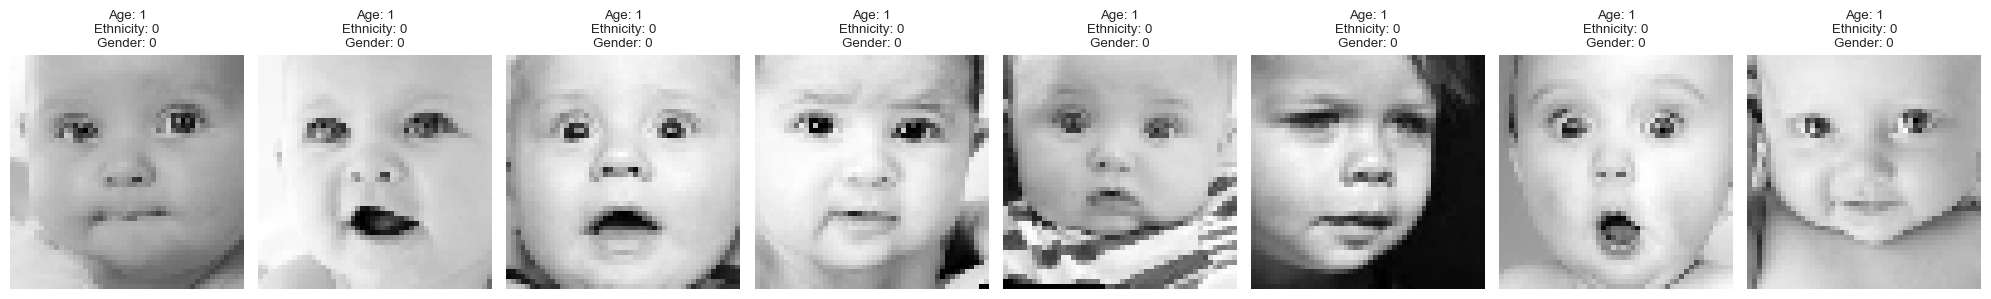

In [18]:
display_filtered_images(age_gender_data_tensor, age=1, ethnicity=0, gender=0, num_images=8)

#### 4.2. display_filtered_images(age_gender_data, age=10, ethnicity=1, gender=1, num_images=8)

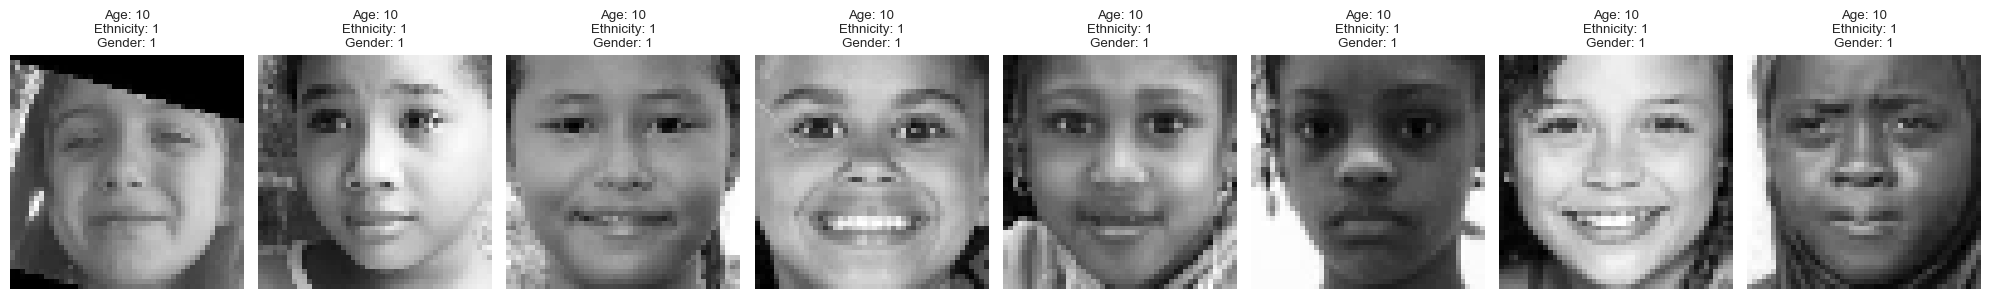

In [19]:
display_filtered_images(age_gender_data_tensor, age=10, ethnicity=1, gender=1, num_images=8)

#### 4.3. display_filtered_images(age_gender_data, age=20, ethnicity=2, gender=0, num_images=8)

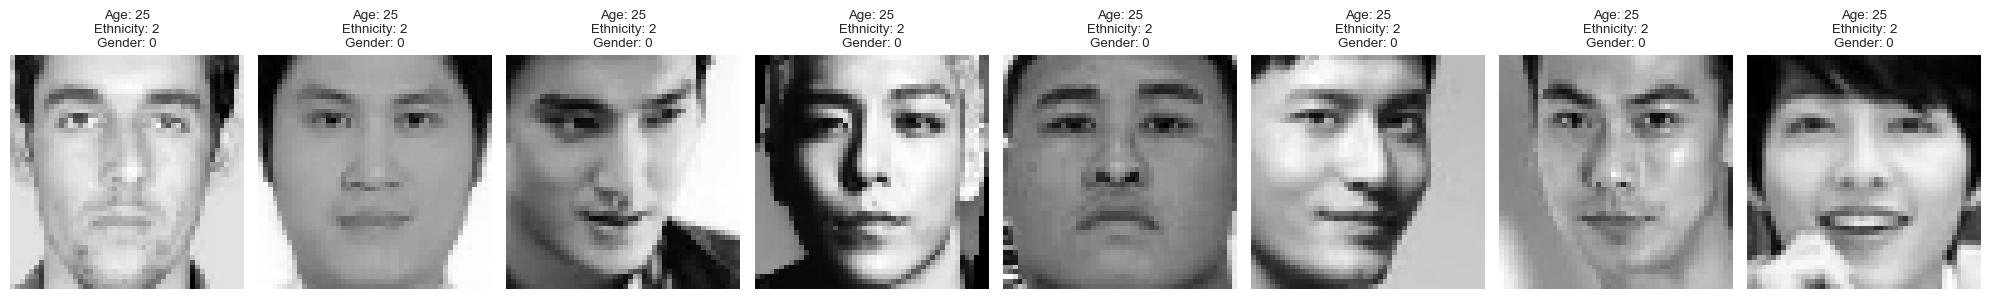

In [20]:
display_filtered_images(age_gender_data_tensor, age=25, ethnicity=2, gender=0, num_images=8)

#### 4.4. display_filtered_images(age_gender_data, age=35, ethnicity=3, gender=1, num_images=8)

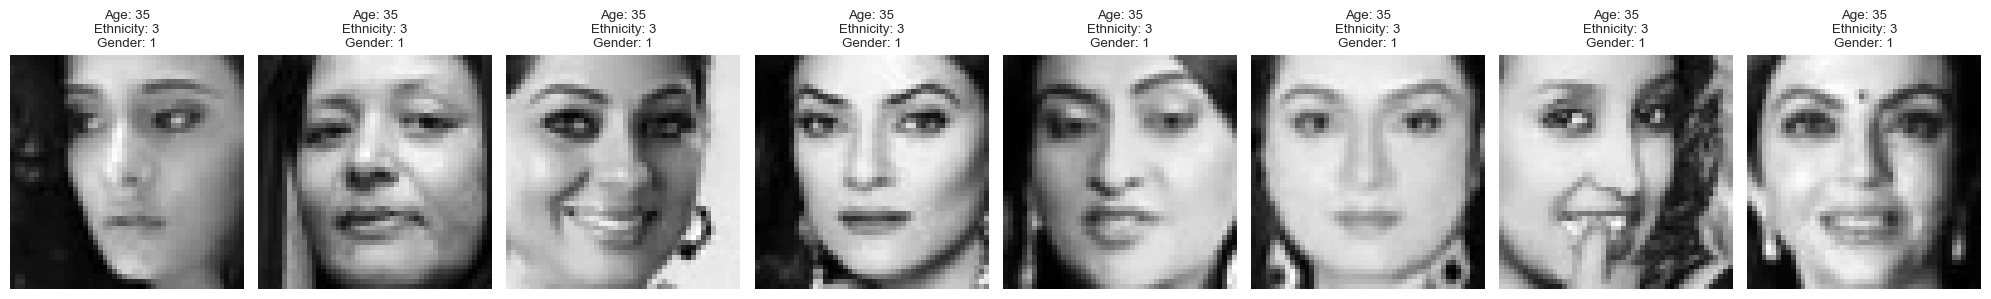

In [21]:
display_filtered_images(age_gender_data_tensor, age=35, ethnicity=3, gender=1, num_images=8)

#### 4.5. display_filtered_images(age_gender_data, age=45, ethnicity=4, gender=0, num_images=8)

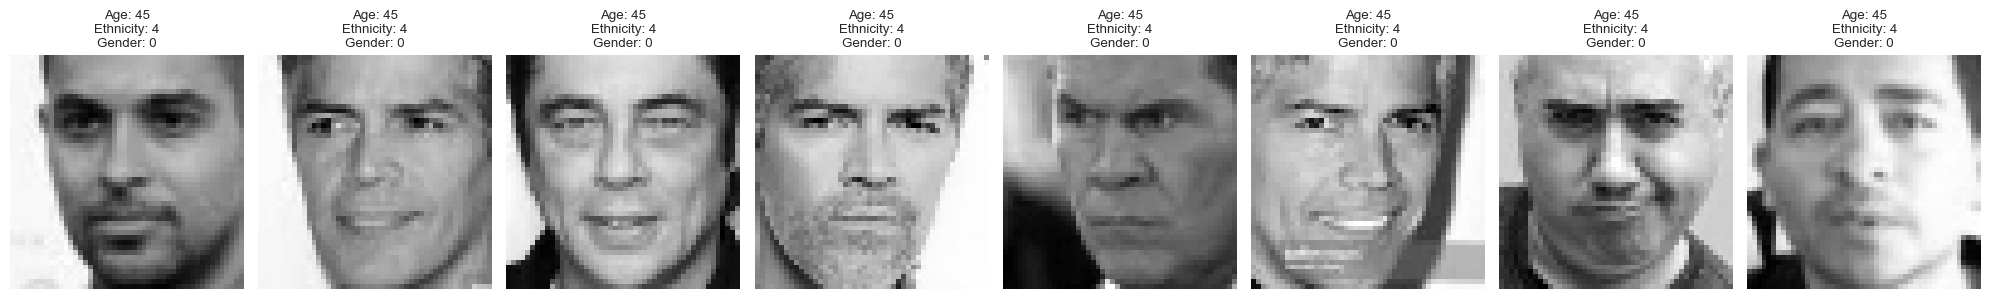

In [22]:
display_filtered_images(age_gender_data_tensor, age=45, ethnicity=4, gender=0, num_images=8)

#### 4.6. display_filtered_images(age_gender_data, age=55, ethnicity=0, gender=1, num_images=8)

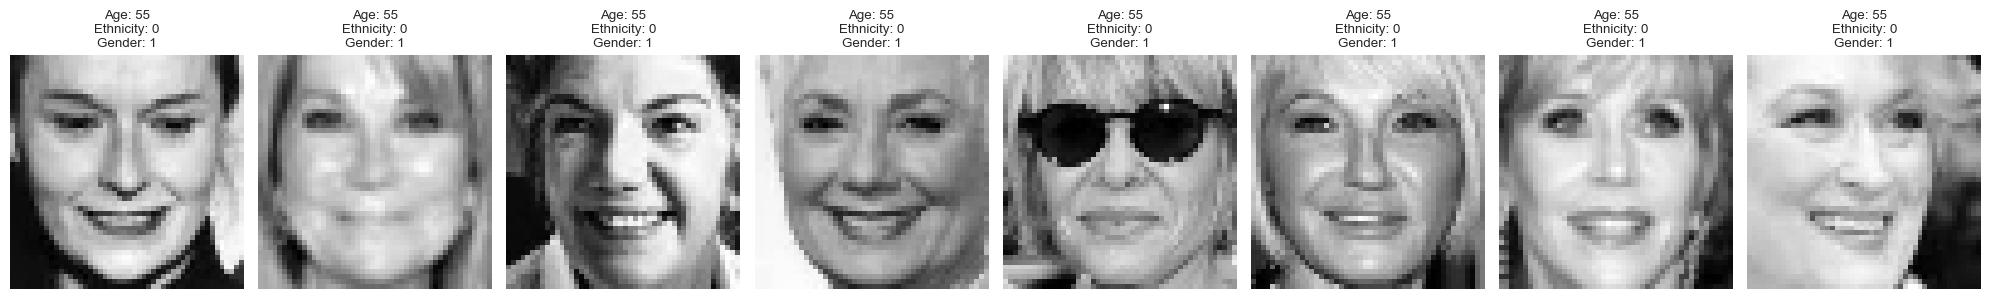

In [23]:
display_filtered_images(age_gender_data_tensor, age=55, ethnicity=0, gender=1, num_images=8)

#### 4.7. display_filtered_images(age_gender_data, age=65, ethnicity=1, gender=0, num_images=8)

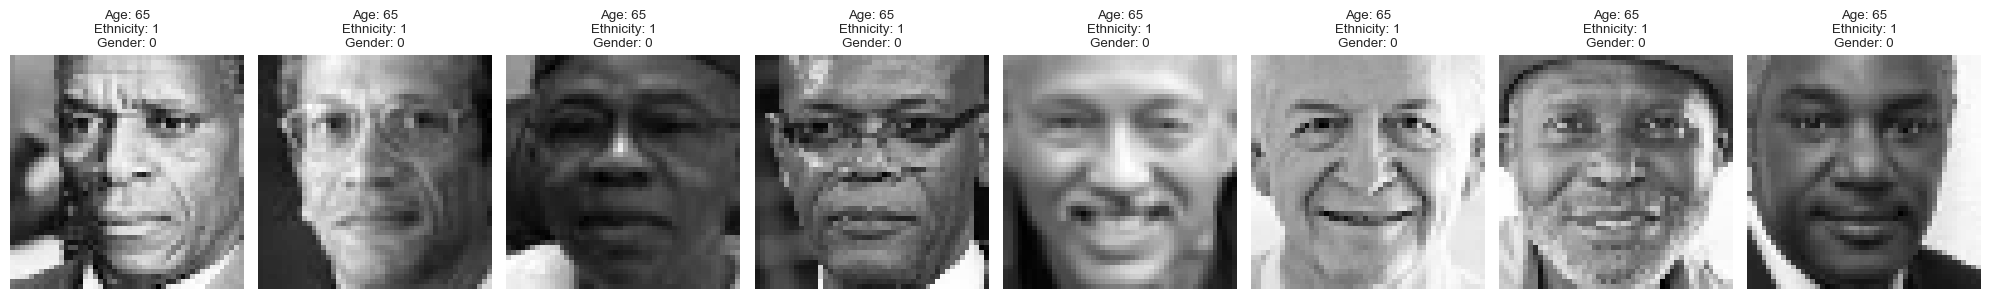

In [24]:
display_filtered_images(age_gender_data_tensor, age=65, ethnicity=1, gender=0, num_images=8)

#### 4.8. display_filtered_images(age_gender_data, age=40, ethnicity=2, gender=1, num_images=8)

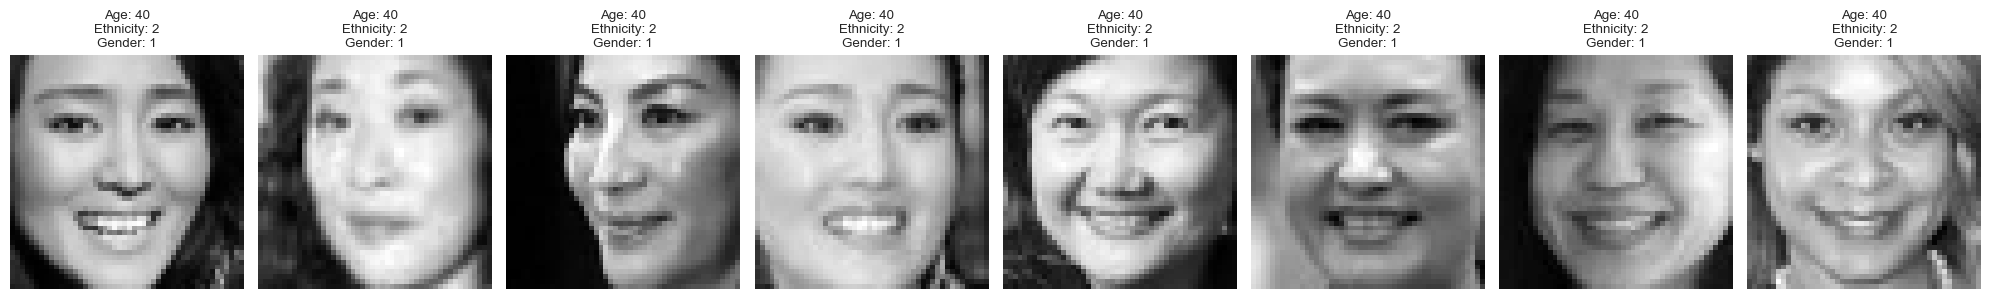

In [25]:
display_filtered_images(age_gender_data_tensor, age=40, ethnicity=2, gender=1, num_images=8)

#### 4.9. display_filtered_images(age_gender_data, age=5, ethnicity=4, gender=1, num_images=8)

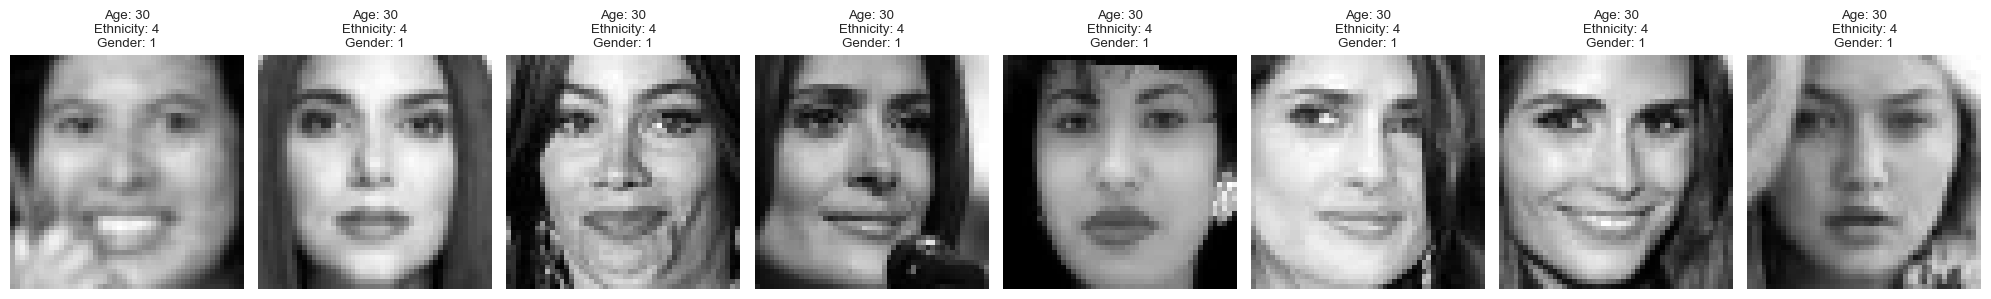

In [26]:
display_filtered_images(age_gender_data_tensor, age=30, ethnicity=4, gender=1, num_images=8)

## 5. Preparing the data for later usage in a neural network

We have a class to carry out the data preprocessing for our neural network. It has the following built-in functions:

1. init

- 1.1. The function returns the training and validation indices. These indices can then be used to create training and validation datasets from the original DataFrame. The advantage of this approach is that it allows for stratified sampling, ensuring that the training and validation sets have the same class distribution as the original dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

2. calculate_stats

- 2.1. This Python code defines a method calculate_stats that calculates the mean and standard deviation of pixel values from a list of pixel strings. It converts each pixel string into a tensor, normalizes the tensor by dividing by 255, and then updates the sum of pixel values, sum of squared pixel values, and total number of pixels. After processing all pixel strings, it calculates and returns the mean and standard deviation.

3. create_dataset

- 3.1. `tf.data.Dataset.from_tensor_slices` function is a convenient way to create a Dataset from data in memory. It creates a dataset where each element is a slice of the input tensors.

https://www.tensorflow.org/api_docs/python/tf/data/Dataset
https://www.tensorflow.org/api_docs/python/tf/numpy_function

- 3.2. `map` function is used to apply a function to each element in the dataset

https://docs.python.org/3/library/functions.html#map

- 3.3. `tf.numpy_function` is a TensorFlow operation that wraps a Python function. the Python function being wrapped is `self.preprocess`, and it's being passed two input tensors: `x` and `y`. `x` and `y` are the pixel data and label for an image, respectively. The dtype of the output tensors are specified as ``tf.float32` and `tf.int64`, which means the preprocess function is expected to return a tuple containing a float32 tensor and an int64 tensor.

- 3.4. The `num_parallel_calls` argument in the map function is set to `tf.data.experimental.AUTOTUNE`, which means that TensorFlow will choose the number of parallel calls to use based on available CPU.

https://www.tensorflow.org/api_docs/python/tf/data/experimental

4. preprocess

- 4.1. The `np.fromstring` function is used to convert a string of pixel values into a numpy array. The `pixel_string.decode('utf-8')` part of the code is decoding a byte string of pixel values into a regular string. The `sep=' '` argument specifies that the pixel values in the string are separated by spaces. The `dtype=np.float32` argument specifies that the data type of the numpy array should be float32.

https://numpy.org/doc/stable/reference/generated/numpy.fromstring.html
https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.float16
https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy-reshape


In [27]:
class DataProcessor:
    def __init__(self, dataframe, label_column, test_size=0.3, random_state=42):
        """
        Initialize the DataProcessor class with a dataframe, the name of the label column,
        split it into training and validation indices, and calculate the mean and standard
        deviation for normalization.

        Args:
            dataframe (pd.DataFrame): The full DataFrame.
            label_column (str): The name of the column to be used as the label.
            test_size (float): The proportion of the dataset to include in the test split.
            random_state (int): The seed used by the random number generator.
        """
        self.dataframe = dataframe
        self.label_column = label_column
        self.indices = np.arange(len(dataframe))
        self.train_indices, self.val_indices, _, _ = train_test_split(
            self.indices, dataframe[label_column].values, test_size=test_size, random_state=random_state)
        
        self.mean, self.std = self.calculate_stats(dataframe['pixels'])

    def calculate_stats(self, pixels_column):
        """Calculate the mean and standard deviation of a column of pixels.
        Args:
            pixels_column (list): A list of strings representing pixel values.
        Returns:
            tuple: A tuple containing the mean and standard deviation of the pixel values.
        """
        sum_pixels = tf.constant(0.0)
        sum_squared_pixels = tf.constant(0.0)
        num_pixels = 0

        for pixel_string in pixels_column:
            tensor = tf.convert_to_tensor([float(pix) for pix in pixel_string.split()], dtype=tf.float32)
            normalized_tensor = tensor / 255.0
            sum_pixels += tf.reduce_sum(normalized_tensor)
            sum_squared_pixels += tf.reduce_sum(tf.square(normalized_tensor))
            num_pixels += tf.size(normalized_tensor).numpy()

        mean = sum_pixels / num_pixels
        std = tf.sqrt((sum_squared_pixels / num_pixels) - tf.square(mean))
        return mean.numpy(), std.numpy()

    def create_dataset(self, dataframe, batch_size=32, shuffle=True):
        """
        Create a TensorFlow dataset from a pandas dataframe.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the data.
            batch_size (int): Batch size.
            shuffle (bool): Whether to shuffle the data.

        Returns:
            tf.data.Dataset: A TensorFlow dataset.
        """
        def preprocess(pixel_string, label):
            """
            Preprocess the pixel string and label.

            Args:
                pixel_string (str): The pixel string.
                label: The label.

            Returns:
                tuple: A tuple containing the preprocessed pixels and label.
            """
            def _preprocess(pixel_string, label):
                """
                Preprocess the pixel string and label.

                Args:
                    pixel_string (str): The pixel string.
                    label: The label.

                Returns:
                    tuple: A tuple containing the preprocessed pixels and label.
                """
                pixels = np.fromstring(pixel_string.decode('utf-8'), sep=' ', dtype=np.float32)
                pixels = pixels.reshape(48, 48, 1)
                pixels = (pixels - self.mean) / self.std
                return pixels, label

            pixels, label = tf.numpy_function(_preprocess, [pixel_string, label], [tf.float32, tf.int64])
            pixels.set_shape((48, 48, 1))
            label.set_shape(())
            return pixels, label

        pixel_strings = dataframe['pixels'].values
        labels = dataframe[self.label_column].values  # Use the label column name passed to the class
        dataset = tf.data.Dataset.from_tensor_slices((pixel_strings, labels))
        dataset = dataset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(dataframe))
        return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    def create_subset_dataset(self, indices, batch_size=32, shuffle=True):
        """
        Creates a subset dataset based on the given indices.

        Parameters:
        - indices (list): List of indices to select from the original dataset.
        - batch_size (int): Number of samples per batch. Default is 32.
        - shuffle (bool): Whether to shuffle the dataset. Default is True.

        Returns:
        - subset_dataset (Dataset): Subset dataset containing the selected samples.
        """
        subset_dataframe = self.dataframe.iloc[indices]
        return self.create_dataset(subset_dataframe, batch_size=batch_size, shuffle=shuffle)

#### 5.1. We instantiate the class and create the train and test datasets. We shuffle the training dataset but we don´t the testing dataset. We select the 'gender' as the target/label for the model.

In [28]:
# Initialize the DataProcessor instance
data_processor = DataProcessor(age_gender_data, 'gender')

# Create the training dataset using the DataProcessor instance
train_dataset_1= data_processor.create_subset_dataset(data_processor.train_indices, batch_size=32, shuffle=True)

# Create the validation dataset using the DataProcessor instance
val_dataset_1 = data_processor.create_subset_dataset(data_processor.val_indices, batch_size=32, shuffle=False)


#### 5.2. We inspect our training and validation datasets to understand their structure and element shapes of a Tensorflow `Dataset` object.

In [29]:
# Example function to inspect dataset structure and element shapes
def inspect_dataset(dataset):
    # Take one batch from the dataset
    for inputs, labels in dataset.take(1):
        # Print the shape of the inputs and labels
        print(f'{Back.RED}Input shape:{Back.RESET}', f"{Back.BLUE}{inputs.shape}{Back.RESET}")
        print(f'{Back.RED}Label shape:{Back.RESET}', f"{Back.BLUE}{labels.shape}{Back.RESET}")
        # Optionally, check the dtype
        print(f'{Back.RED}Input dtype:{Back.RESET}', f"{Back.BLUE}{inputs.dtype}{Back.RESET}")
        print(f'{Back.RED}Label dtype:{Back.RESET}', f"{Back.BLUE}{labels.dtype}{Back.RESET}")

# Assuming train_dataset and val_dataset are your datasets
print(f'{Back.RED}Training Dataset:{Back.RESET}')
inspect_dataset(train_dataset_1)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(train_dataset_1)}{Back.RESET}")
print(f'{Back.RED}Validation Dataset:{Back.RESET}')
inspect_dataset(val_dataset_1)
print(f'{Back.RED}Type:{Back.RESET}', f"{Back.BLUE}{type(val_dataset_1)}{Back.RESET}")

Training Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Validation Dataset:
Input shape: (32, 48, 48, 1)
Label shape: (32,)
Input dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int64'>
Type: <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


#### 5.3. We plot some pictures to ensure we are going in the right direction.

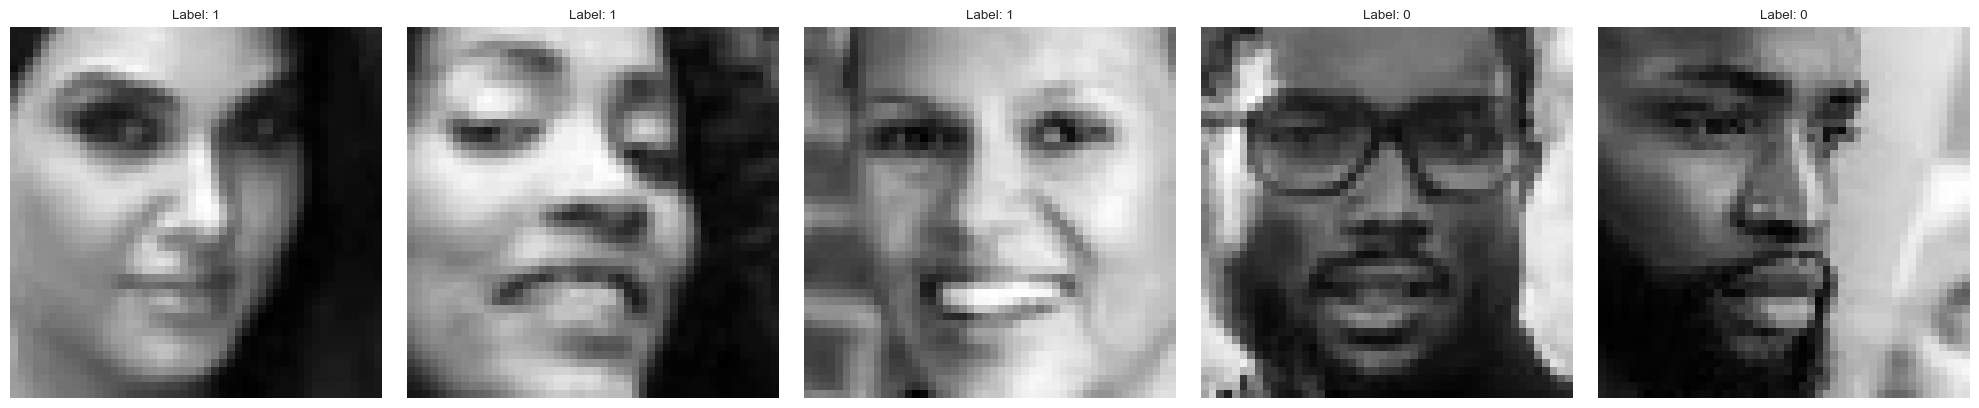

In [30]:
# Adjust 'num_images' to display the desired number of images
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

for i, (images, labels) in enumerate(train_dataset_1.take(num_images)):
    img_array = images[0].numpy().squeeze()  # Select the first image in the batch and remove singleton dimensions
    ax = axes[i]
    ax.imshow(img_array, cmap='gray')  # Display the image in grayscale
    title = f"Label: {labels[0].numpy()}"  # Display the label for the first image
    ax.set_title(title)  # Set the title with label information
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


## 6. We train our first model: a single layer perceptron.


```python
model = models.Sequential([
    layers.Flatten(input_shape=(48, 48, 1)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
```

https://keras.io/guides/sequential_model/

The `models.Sequential` function is a constructor for a Sequential model. The Sequential model is a linear stack of layers, where you can just add one layer at a time in a sequential manner.

https://keras.io/api/layers/reshaping_layers/flatten/

The `Flatten` layer is used to flatten the input. It does this by converting a multi-dimensional tensor into a one-dimensional tensor (also known as a vector).

https://keras.io/api/layers/core_layers/dense/

The `Dense` layer performs a dot product between the input and a set of learned weights, and then adds a bias term to the result. It's called a `Dense` layer because every neuron in a `Dense` layer is connected to every neuron in the previous layer. The `Dense` layer takes two arguments:
- The first argument, 64, is the number of neurons (also known as nodes) in the layer. The number of neurons is a hyperparameter.
- The second argument, `activation='relu'`, specifies the activation function to use after performing the dot product and adding the bias.

https://keras.io/api/layers/activations/

The sigmoid function is often used in the output layer of a binary classification model because it squashes its input into the range [0, 1], which can be interpreted as a probability.



#### 6.1. We define the first model.

In [31]:
# Simplified model
model = models.Sequential([
    # Flatten the input layer
    layers.Flatten(input_shape=(48, 48, 1)),  # Assuming grayscale images
    # Single fully connected layer
    layers.Dense(64, activation='relu'),
    # Output layer with 1 unit for binary classification, using sigmoid for binary classification
    layers.Dense(1, activation='sigmoid')
])

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

The optimizer is responsible for updating the weights of the network in response to the error it makes on the training data. The goal of the optimizer is to minimize this error, and the way it does this is by adjusting the weights in the direction that makes the error smaller. This process is known as gradient descent.

The `tf.keras.optimizers.Adam` function is used to create an instance of the Adam optimizer. Adam is a popular choice of optimizer because it combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.

In [32]:
# Using Adam as a more adaptive optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function

The loss function is a measure of how well the model's predictions match the true values. During training, the goal of the optimizer is to minimize the value of the loss function.

The `tf.keras.losses.BinaryCrossentropy` function is used to create an instance of the Binary Cross-Entropy loss. Binary Cross-Entropy loss is used in binary classification tasks, where each input can belong to one of two classes. It measures the "distance" between the model's predictions and the true values.

In [33]:
loss_function = tf.keras.losses.BinaryCrossentropy()

https://keras.io/api/metrics/classification_metrics/#f1score-class

The `tf.keras.metrics.BinaryAccuracy` function is used to create an instance of the Binary Accuracy metric.

The threshold parameter is set to 0.5. This means that the model's predicted probabilities that the inputs belong to the positive class will be rounded to the nearest integer to obtain the predicted classes. If the predicted probability is greater than or equal to 0.5, the predicted class is 1 (the positive class); otherwise, the predicted class is 0 (the negative class).

In [34]:
metric = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

https://keras.io/api/models/model_training_apis/

https://keras.io/api/losses/

https://keras.io/api/metrics/

The `model.compile` method is used to configure the learning process before training the model. It takes three main arguments: an optimizer, a loss function, and a list of metrics.

In [35]:
# Compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metric)

#### 6.2. We dig deeper into the model features

In [36]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                147520    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 147,585
Trainable params: 147,585
Non-trainable params: 0
_________________________________________________________________


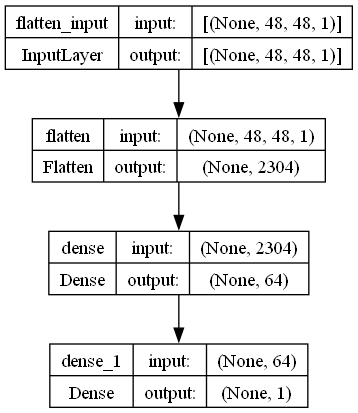

In [37]:
# Visualize the model
plot_model(model, show_shapes=True, show_layer_names=True, rankdir='TB')

#### 6.3. We train our model

In [38]:
start_time = time.time()
history = model.fit(train_dataset_1,
                    epochs=1,
                    validation_data=val_dataset_1
                    )
end_time = time.time()

519/519 [==============================] - 116s 65ms/step - loss: 34.4370 - binary_accuracy: 0.7024 - val_loss: 8.1666 - val_binary_accuracy: 0.8036


#### 6.4. Training time

In [39]:
# Calculate and print the duration
duration_mins = (end_time - start_time)/60
print(f'{Back.RED}Training completed in (mins):{Back.RESET}',
    f"\n{Back.BLUE}{duration_mins:.3f}{Back.RESET}")

Training completed in (mins): 
1.938


#### 6.5. Model evaluation

223/223 [==============================] - 33s 150ms/step


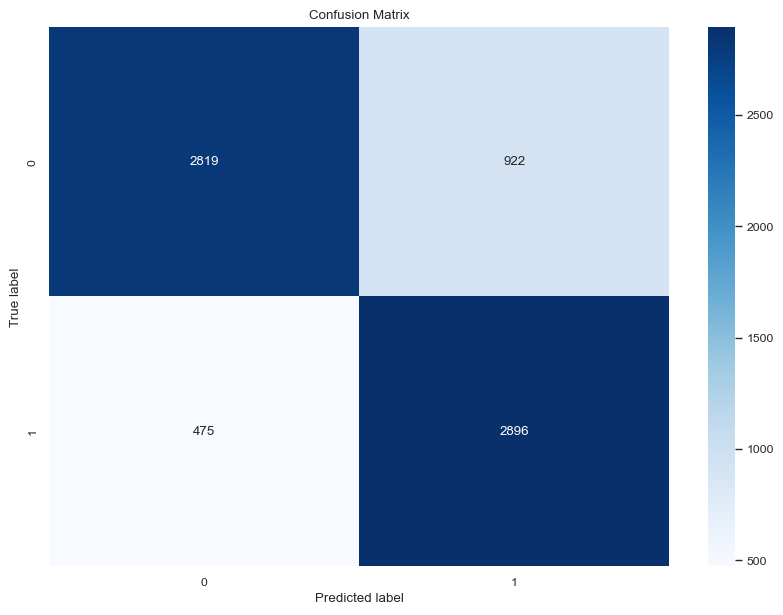

              precision    recall  f1-score   support

     Class 0       0.86      0.75      0.80      3741
     Class 1       0.76      0.86      0.81      3371

    accuracy                           0.80      7112
   macro avg       0.81      0.81      0.80      7112
weighted avg       0.81      0.80      0.80      7112

Accuracy: 80.36%


In [40]:

# Predict the labels for the validation set
y_pred_probs = model.predict(val_dataset_1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

#y_pred = (y_pred_probs > 0.5).astype(int)  # Threshold probabilities to get binary class labels

# Extract true labels from the validation dataset
y_true = np.concatenate([np.array([y.numpy()]) for x, y in val_dataset_1.unbatch()], axis=0)


# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report for all metrics
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# Calculate and print the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


#### 6.6. Visual inspection of missclassified pictures

In [41]:
# Threshold probabilities to get binary class labels
#y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)
misclassified_indices = np.where(y_pred != y_true)[0]

In [42]:
def display_misclassified_images(dataset, misclassified_indices, num_images=10):
    """
    Display misclassified images from the dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing images and labels.
        misclassified_indices (np.array): Array containing indices of misclassified images.
        num_images (int): Number of misclassified images to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    i = 0  # Index for subplot
    count = 0  # Count to keep track of how many images we have displayed
    
    for idx, (image, label) in enumerate(dataset.unbatch()):
        if idx in misclassified_indices and count < num_images:
            img = image.numpy().squeeze()
            ax = axes[i]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True: {label.numpy()}, Pred: {y_pred[idx]}")
            ax.axis('off')
            i += 1
            count += 1
        
        if count >= num_images:
            break

    plt.tight_layout()
    plt.show()


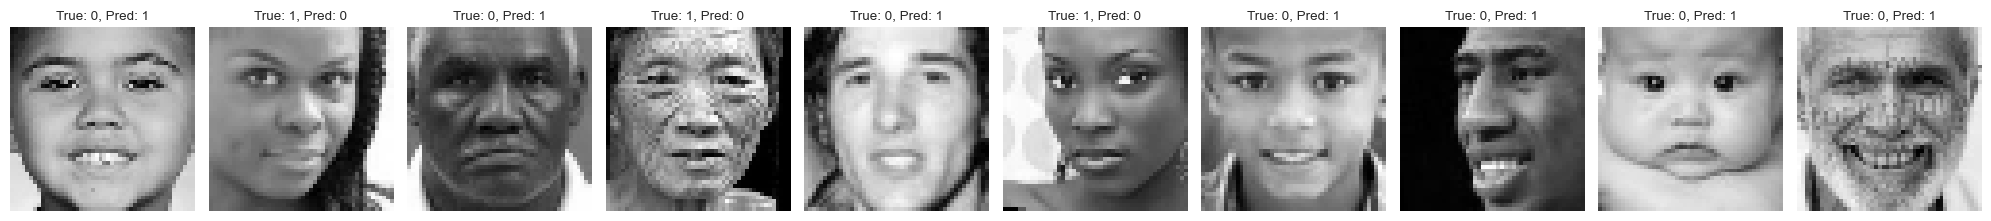

In [43]:

# Now call the function to display the misclassified images
display_misclassified_images(val_dataset_1, misclassified_indices)

In [44]:
# Example usage:
calculate_combined_misclassification_info(
    y_true, 
    y_pred, 
    age_gender_data, 
    category_names=['age', 'ethnicity', 'gender']
)



age - Misclassification rates:
  0-4: Total = 1605, Misclassified = 296 (18.44%)
  10-14: Total = 589, Misclassified = 131 (22.24%)
  100-104: Total = 14, Misclassified = 1 (7.14%)
  105-109: Total = 5, Misclassified = 1 (20.00%)
  110-114: Total = 6, Misclassified = 0 (0.00%)
  115-119: Total = 7, Misclassified = 4 (57.14%)
  15-19: Total = 942, Misclassified = 194 (20.59%)
  20-24: Total = 2310, Misclassified = 436 (18.87%)
  25-29: Total = 1634, Misclassified = 334 (20.44%)

age - Misclassification distribution:
  0-4: Misclassified = 296 (21.19%) of Total Misclassified = 1397
  10-14: Misclassified = 131 (9.38%) of Total Misclassified = 1397
  100-104: Misclassified = 1 (0.07%) of Total Misclassified = 1397
  105-109: Misclassified = 1 (0.07%) of Total Misclassified = 1397
  110-114: Misclassified = 0 (0.00%) of Total Misclassified = 1397
  115-119: Misclassified = 4 (0.29%) of Total Misclassified = 1397
  15-19: Misclassified = 194 (13.89%) of Total Misclassified = 1397
  20-24: 

## 7. We train our second model by seeking the hyper-parameters 

In [45]:
import keras_tuner as kt
from tensorflow import keras


def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(48, 48, 1)))

    # Hyperparameter for the activation function of the first dense layer
    activation_choice = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid','leaky_relu'])
    
    # Hyperparameter for the number of units in the first dense layer
    units_choice = hp.Int('units', min_value=32, max_value=512, step=32)

    model.add(keras.layers.Dense(units=units_choice, activation=activation_choice))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Hyperparameters for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss_function = keras.losses.BinaryCrossentropy()

    # You can define multiple metrics and Keras Tuner will consider the first one for optimization
    metrics = [keras.metrics.BinaryAccuracy(threshold=0.5),
               keras.metrics.AUC()]

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)
    
    return model


In [46]:

# Bayesian optimization tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_binary_accuracy',  # Change this if you want to optimize a different metric
    max_trials=10,  # Number of variations on the hyperparameters
    directory='keras_tuner_bayesian',
    project_name='gender_classification',
    seed=42  # Random seed for reproducibility
)

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Start the hyperparameter tuning process
tuner.search(train_dataset_1,
             epochs=2,
             validation_data=val_dataset_1,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal activation function is {best_hps.get('activation')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset_1, epochs=2, validation_data=val_dataset_1)


Trial 10 Complete [00h 03m 45s]
val_binary_accuracy: 0.815523087978363

Best val_binary_accuracy So Far: 0.8256468176841736
Total elapsed time: 00h 37m 15s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal activation function is leaky_relu.
The optimal learning rate for the optimizer is 0.008547485565344062.

Epoch 1/2
519/519 [==============================] - 112s 67ms/step - loss: 329.1775 - binary_accuracy: 0.6968 - auc_1: 0.6973 - val_loss: 73.4449 - val_binary_accuracy: 0.7859 - val_auc_1: 0.7922
Epoch 2/2
519/519 [==============================] - 111s 64ms/step - loss: 117.7490 - binary_accuracy: 0.7413 - auc_1: 0.7426 - val_loss: 41.4491 - val_binary_accuracy: 0.8268 - val_auc_1: 0.8293


In [47]:
history = model.fit(train_dataset_1, epochs=10, validation_data=val_dataset_1)


Epoch 1/10
519/519 [==============================] - 109s 66ms/step - loss: 45.2235 - binary_accuracy: 0.7808 - auc_1: 0.7833 - val_loss: 16.2761 - val_binary_accuracy: 0.8235 - val_auc_1: 0.8266
Epoch 2/10
519/519 [==============================] - 110s 67ms/step - loss: 21.1170 - binary_accuracy: 0.7818 - auc_1: 0.7881 - val_loss: 17.2334 - val_binary_accuracy: 0.6849 - val_auc_1: 0.7184
Epoch 3/10
519/519 [==============================] - 113s 68ms/step - loss: 5.8311 - binary_accuracy: 0.7845 - auc_1: 0.8073 - val_loss: 1.1767 - val_binary_accuracy: 0.8117 - val_auc_1: 0.8736
Epoch 4/10
519/519 [==============================] - 113s 67ms/step - loss: 0.8751 - binary_accuracy: 0.8061 - auc_1: 0.8715 - val_loss: 0.4819 - val_binary_accuracy: 0.7915 - val_auc_1: 0.9117
Epoch 5/10
519/519 [==============================] - 113s 68ms/step - loss: 13.0486 - binary_accuracy: 0.7471 - auc_1: 0.7703 - val_loss: 1.8493 - val_binary_accuracy: 0.7801 - val_auc_1: 0.8437
Epoch 6/10
519/519 [

In [49]:
# List all data in history
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'auc_1', 'val_loss', 'val_binary_accuracy', 'val_auc_1'])


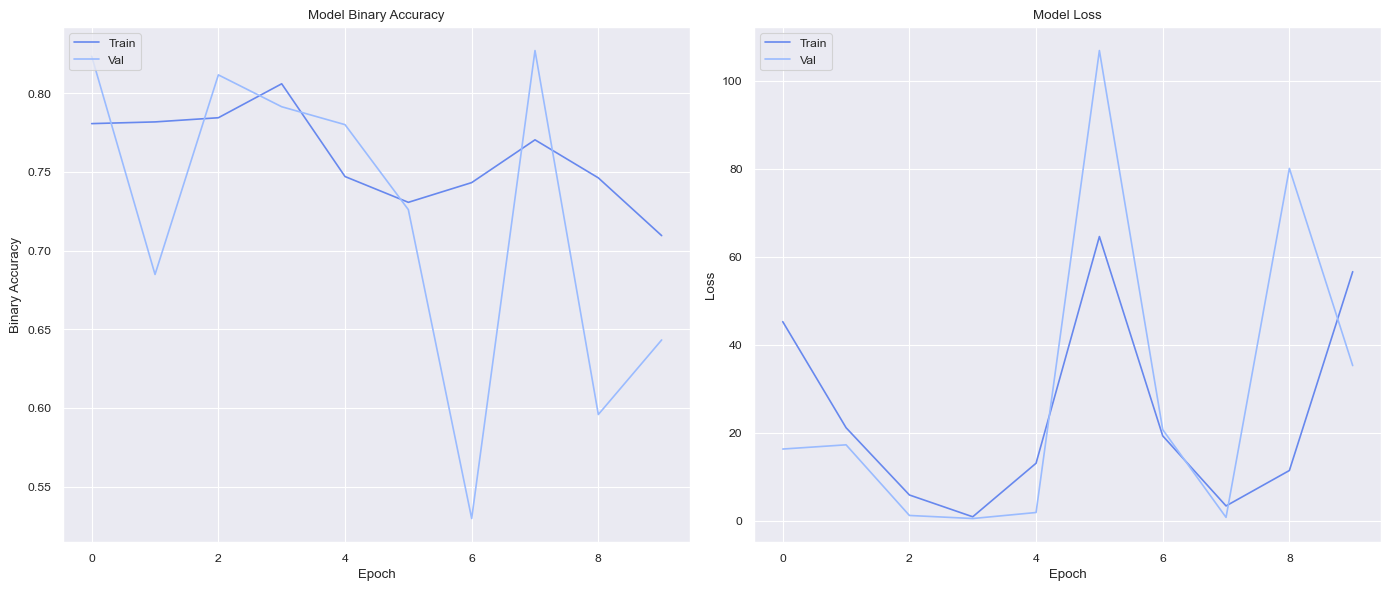

In [52]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Binary Accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

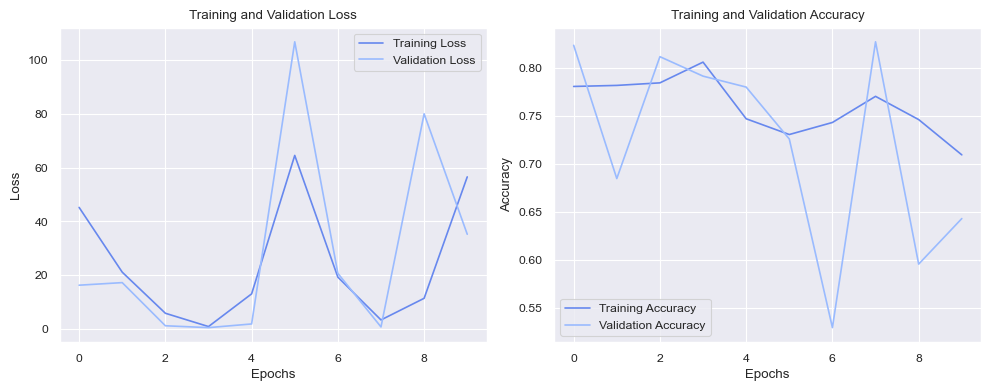

In [53]:
# Plotting training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
import keras_tuner as kt
from tensorflow import keras


def build_model_v2(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(48, 48, 1)))

    # Hyperparameter for the activation function of the first dense layer
    activation_choice = hp.Choice('activation', values=['relu', 'gelu','leaky_relu'])
    
    # Hyperparameter for the number of units in the first dense layer
    units_choice = hp.Int('units', min_value=64, max_value=512, step=32)

    model.add(keras.layers.Dense(units=units_choice, activation=activation_choice))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Hyperparameters for the optimizer
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss_function = keras.losses.BinaryCrossentropy()

    # You can define multiple metrics and Keras Tuner will consider the first one for optimization
    metrics = [keras.metrics.BinaryAccuracy(threshold=0.5),
               keras.metrics.AUC()]

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=metrics)
    
    return model


In [64]:
# Bayesian optimization tuner
tuner_2 = kt.BayesianOptimization(
    build_model_v2,
    objective='val_binary_accuracy',  # Change this if you want to optimize a different metric
    max_trials=10,  # Number of variations on the hyperparameters
    directory='keras_tuner_bayesian',
    project_name='gender_classification_v2',
    seed=42  # Random seed for reproducibility
)

# Early stopping callback
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Start the hyperparameter tuning process
tuner_2.search(train_dataset_1,
             epochs=3,
             validation_data=val_dataset_1,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner_2.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal activation function is {best_hps.get('activation')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner_2.hypermodel.build(best_hps)



Trial 9 Complete [15h 06m 29s]
val_binary_accuracy: 0.8321147561073303

Best val_binary_accuracy So Far: 0.8321147561073303
Total elapsed time: 15h 52m 11s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
gelu              |relu              |activation
512               |96                |units
0.0029106         |0.0030433         |learning_rate



c:\Users\fercv\anaconda3\envs\tensorflow_env_ok\lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 1/3
519/519 [==============================] - ETA: 0s - loss: 197.3693 - binary_accuracy: 0.6976 - auc: 0.7015     

KeyboardInterrupt: 

In [ ]:
class LearningRateLogger(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.learning_rates.append(self.model.optimizer.lr.numpy())

# Include this callback during training
lr_logger = LearningRateLogger()


In [ ]:
history = model.fit(train_dataset_1, epochs=50, validation_data=val_dataset_1, callbacks=[lr_logger, stop_early])

In [ ]:
# Plotting Learning Rate against Loss
plt.figure(figsize=(10, 5))
plt.plot(lr_logger.learning_rates, history.history['loss'])
plt.title('Learning Rate vs Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

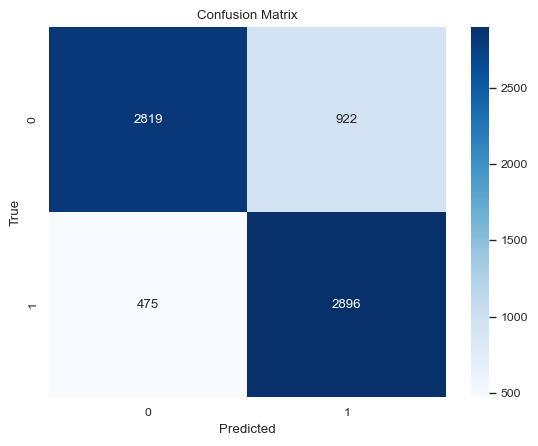

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are available
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

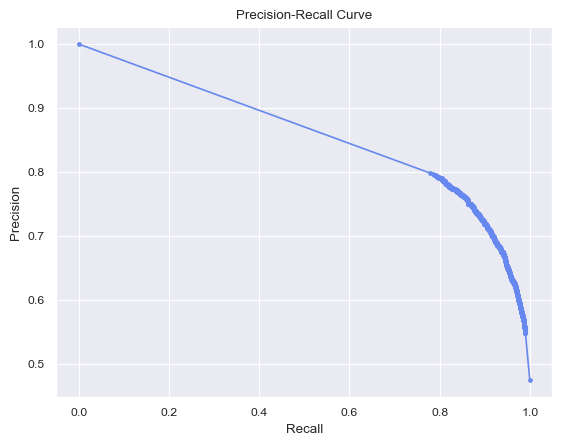

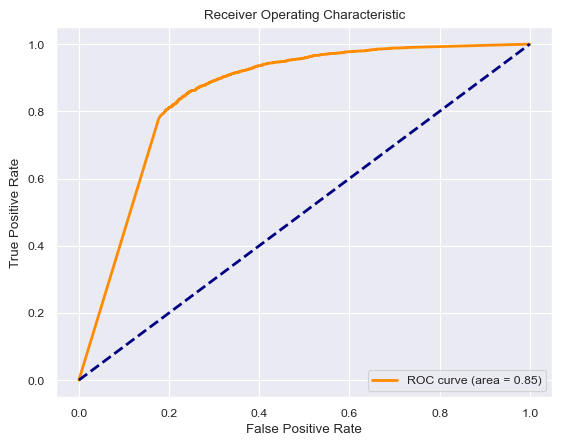

In [55]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


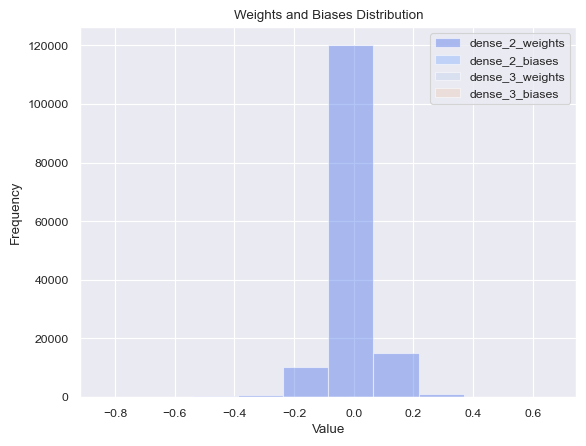

In [57]:
for layer in model.layers:
    if 'dense' in layer.name:
        weights, biases = layer.get_weights()
        plt.hist(weights.flatten(), alpha=0.5, label=f'{layer.name}_weights')
        plt.hist(biases.flatten(), alpha=0.5, label=f'{layer.name}_biases')
plt.legend()
plt.title('Weights and Biases Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
